### Viz 1: Merged PBH

Merging pbh candidates into a single spectrogram

In [1]:
import logging
import h5py
import json
import readligo as rl
import matplotlib.mlab as mlab
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [2]:
def get_data(file):
    try:
        events = json.load(open(file,"r"))
    except IOError:
        print("Cannot find resource file "+ fnjson)

    data = {}

    for k, event in events.items():

        fn_H1 = event['fn_H1']              # File name for H1 data
        fn_L1 = event['fn_L1']              # File name for L1 data
        fn_template = event['fn_template']  # File name for template waveform
        fs = event['fs']                    # Set sampling rate
        tevent = event['tevent']            # Set approximate event GPS time
        fband = event['fband'] 

        try:
            # read in data from H1 and L1, if available:
            strain_H1, time_H1, chan_dict_H1 = rl.loaddata(fn_H1, 'H1')
            strain_L1, time_L1, chan_dict_L1 = rl.loaddata(fn_L1, 'L1')
            data[k] = {'fband': fband, 'fs': fs, 'tevent': tevent,
            'H1': {'strain': strain_H1, 'time': time_H1, 'chan_dict': chan_dict_H1}, 
            'L1': {'strain': strain_L1, 'time': time_L1, 'chan_dict': chan_dict_L1}}
        except:
            print("Can't find {} can download them from https://losc.ligo.org/s/events/".format(k), k)
        print("Found {}".format(k))
    return data

data = get_data("BBH_events_v3.json")

Found GW150914
Found LVT151012
Found GW151226
Found GW170104


/home/andor/workspace/src/github.com/andorsk/a_novel_approach_toward_tda_paper/notebooks/readligo.py:155: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  shortnameArray = dqInfo['DQShortnames'].value
/home/andor/workspace/src/github.com/andorsk/a_novel_approach_toward_tda_paper/notebooks/readligo.py:161: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  injnameArray = injInfo['InjShortnames'].value
/home/andor/workspace/src/github.com/andorsk/a_novel_approach_toward_tda_paper/notebooks/readligo.py:166: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  gpsStart = meta['GPSstart'].value


In [3]:
secondary_data = json.load(open('/home/andor/Downloads/1pK7FC7v.json', 'r'))

Failed to make spectrogram name 'make_spectrogram' is not defined


NameError: name 't' is not defined

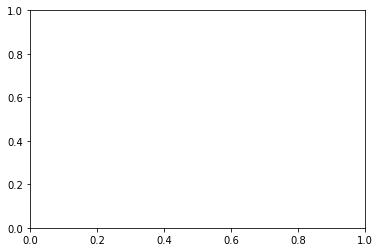

In [4]:
strain_H1, time_H1, chan_dict_H1 = rl.loaddata('/home/andor/Downloads/H-H1_GWOSC_4KHZ_R1-1242440920-4096.hdf5', 'H1')
GW190521 = {
    'H1':{
        'strain': strain_H1, 
        'time': time_H1,
     },
    'tevent': secondary_data['events']['GW190521-v3']['GPS'],
    'fband': [0, 432.0],
    'fs': 4096.0,
    'name': 'GW190521',
    'secondary_data': secondary_data['events']['GW190521-v3']
}


#whitened_event = whiten_data(GW190521)
try:
    f,t,Sxx = make_spectrogram(GW190521)
except Exception as e:
    print("Failed to make spectrogram {}".format(e))
#ax = axes[count%2,int(np.floor((count-1)/2))]
ax = plt.gca()
ax.pcolormesh(t,f,Sxx,shading='gouraud', cmap='ocean')
ax.set_ylabel('Frequency [Hz]')
ax.set_xlabel('Time [sec]')
ax.set_title(k)
ax.set_ylim(0,100)
ax.set_xlim(4,6)
plt.show()


In [ ]:
import numpy as np
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz, spectrogram
from scipy import signal

def whiten_data(data):
    logger.info("Whitening data..")
    time = data['H1']['time']
    dt = time[1] - time[0]
    fs = data['fs']
    fband = data['fband']
    NFFT = 4*data['fs']
    bb, ab = butter(4, [fband[0]*2./fs, fband[1]*2./fs], btype='band')
    normalization = np.sqrt((fband[1]-fband[0])/(fs/2))
    for x in ['H1', 'L1']:
        pxx, freqs = mlab.psd(data[x]['strain'], Fs = data['fs'], NFFT = NFFT)
        psd_H1 = interp1d(freqs, pxx)
        data[x]['strain'] = whiten(data[x]['strain'], psd_H1, dt)
        data[x]['strain_bp'] = filtfilt(bb, ab, data[x]['strain']) / normalization
    return data 

# function to whiten data
def whiten(strain, interp_psd, dt):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)
    freqs1 = np.linspace(0,2048.,int(Nt/2+1))

    # whitening: transform to freq domain, divide by asd, then transform back, 
    # taking care to get normalization right.
    hf = np.fft.rfft(strain)
    norm = 1./np.sqrt(1./(dt*2))
    white_hf = hf / np.sqrt(interp_psd(freqs)) * norm
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht


def make_spectrogram(data, key='H1', deltat=5):
    time = data[key]['time']
    fs = data['fs']
    tevent = data['tevent']
    indxt = np.where((time >= tevent-deltat) & (time < tevent+deltat))
    NFFT = int(fs/16.0)
    NOVL = int(NFFT*15./16)
    window = np.blackman(NFFT)        
    f, t, Sxx = signal.spectrogram(x=data[key]['strain'][indxt], nfft=NFFT, noverlap=NOVL, fs=fs, window=window)
    return f,t,Sxx

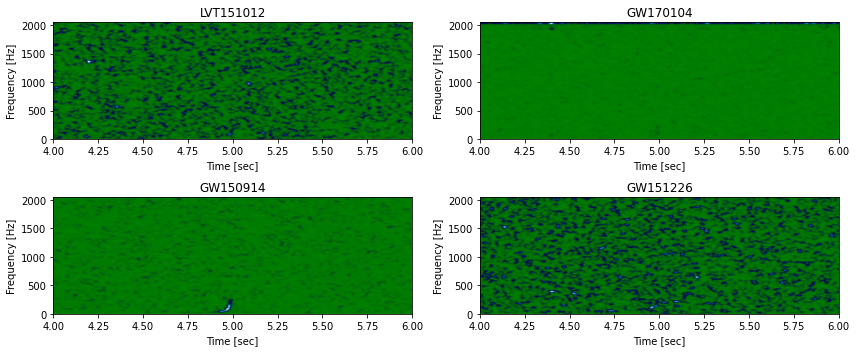

In [8]:
fig, axes = plt.subplots(2,2, figsize=(12,5))

count = 0
for k, event in data.items():
    count += 1
    whitened_event = whiten_data(event)
    try:
        f,t,Sxx = make_spectrogram(whitened_event)
    except Exception as e:
        print("Failed to make spectrogram {}".format(e))
        continue
    ax = axes[count%2,int(np.floor((count-1)/2))]
    ax.pcolormesh(t,f,Sxx,shading='gouraud', cmap='ocean')
    ax.set_ylabel('Frequency [Hz]')
    ax.set_xlabel('Time [sec]')
    ax.set_xlim(4,6)
    ax.set_title(k)

plt.tight_layout()
plt.show()

### Sample Visualization

NameError: name 'np' is not defined

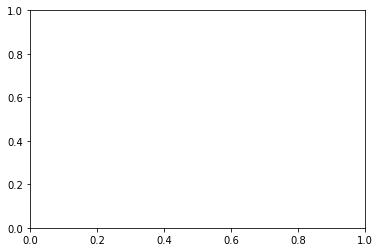

In [7]:
ax = plt.gca()
import pandas as pd
df = pd.DataFrame()

mu = (50,50)
cov = np.array([[100,0,0],[0,100,0],[0,0,100]])
d1 = np.random.rand(100000, 3)*100
ax.scatter(d1[:,0], d1[:,1])
df = pd.concat([df, pd.DataFrame(d1)])

for i in range(4):
    mu = (np.random.rand(1,3)*100)[0]
    cov = np.array([[np.random.rand(1)[0]*20,0,0],[0,np.random.rand(1)[0]*50,0],[0,0, 20]])
    d1 = np.random.multivariate_normal(mu, cov, 50000)
    ax.scatter(d1[:,0], d1[:,1])
    df = pd.concat([df, pd.DataFrame(d1)])
 
# for i in range(10):
#     mu = (np.random.rand(1,2)*100)[0].tolist()
#     mu.extend((np.random.rand(1,1)*10).tolist()[0])
#     print(mu)
#     cov = np.array([[np.random.rand(1)[0]*20,0,0],[0,np.random.rand(1)[0]*20,0],[0,0, 2]])
#     d1 = np.random.multivariate_normal(mu, cov, 10000)
#     ax.scatter(d1[:,0], d1[:,1])
#     df = pd.concat([df, pd.DataFrame(d1)])  
    
df[df[2]<0] = 0

plt.show()

In [8]:
plt.scatter(df[0], df[1], c=df[2])

KeyError: 0

In [9]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import cm
df = pd.read_csv("random_data_for_visualiation.csv", index_col=0)
df.columns = [0,1,2]
#df.to_csv("random_data_for_visualiation.csv")

In [10]:
df.columns

Int64Index([0, 1, 2], dtype='int64')

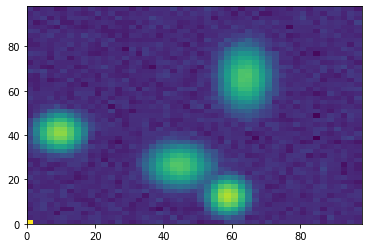

In [11]:
ax = plt.gca()
yedges = np.arange(0, 100,2)
xedges = np.arange(0, 100,2)
H, xedges, yedges = np.histogram2d(df[0], df[1], bins=(xedges, yedges))
H = H.T  # Let each row list bins with common y range.
H = np.log(H)
X, Y = np.meshgrid(xedges, yedges)
ax.pcolormesh(X, Y, H)
plt.show()

In [12]:
X=X[1:,1:]
Y=Y[1:,1:]

<ipython-input-16-b0b4f17a7fda>:48: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


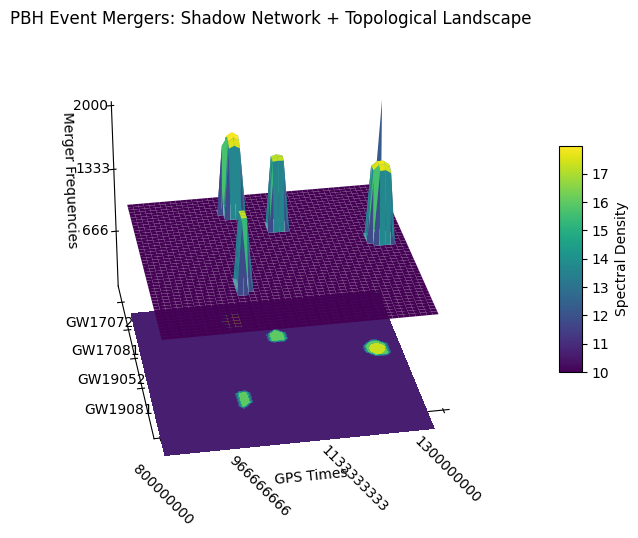

In [16]:

fig = plt.figure(figsize=(16,6), dpi=100)
ax = fig.add_subplot(111, projection='3d')

cmap='viridis'
#surf = ax.plot_surface(X, Y, H, rstride=20, cstride=20, alpha=0.8, cmap=cmap)
#surf = ax.plot_surface(X, Y, H, rstride=20, cstride=20, alpha=0.8, cmap=cmap)
H2=H
#H2 = maximum_filter(H, size=4)
H2[H2<7]=0
#H2 = gaussian_gradient_magnitude(H2, sigma=4)

surf = ax.plot_surface(X, Y, H2+10, cmap='viridis')
cset = ax.contourf(X, Y, H2, zdir='z', offset=np.min(H2)-2, cmap=cmap)
#cset = ax.contourf(X, Y, H, zdir='x', offset=5, cmap=cmap)
#cset = ax.contourf(X, Y, H, zdir='y', offset=5, cmap=cmap)

bar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
bar.set_label("Spectral Density")
ax.set_xlabel('GPS Times')
ax.set_xlim(0,100)
ax.set_ylim(0, 100)
ax.set_zlabel('Merger Frequencies')
ax.set_zlim(np.min(H2)-100, np.max(H2))
ax.set_title('PBH Event Mergers: Shadow Network + Topological Landscape')
#ax.axis('off')
plt.grid(b=None)

ax.set_yticks([10,30,50,70])
ax.set_yticklabels(['GW170729','GW170817','GW190521','GW190814'])

ax.set_zticks(np.linspace(0,20,4))
ax.set_zticklabels(np.linspace(0,2000,4).astype(int))

ax.set_xticks(np.linspace(0,100,4))
ax.set_xticklabels(np.linspace(1300000000,800000000,4).astype(int))
# make the panes transparent
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

ax.set_zlim(1,20)
plt.xticks(rotation=-45)
ax.view_init(30, 80)
plt.tight_layout()
plt.show()


In [17]:
from scipy.ndimage.filters import gaussian_filter, median_filter, gaussian_gradient_magnitude, maximum_filter, minimum_filter
from scipy import ndimage, misc
from sklearn.preprocessing import MinMaxScaler

### Viz 3: R-K Models

In [18]:
H3 = H2
H3[H3>3] = 1

<ipython-input-22-55116560c794>:49: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


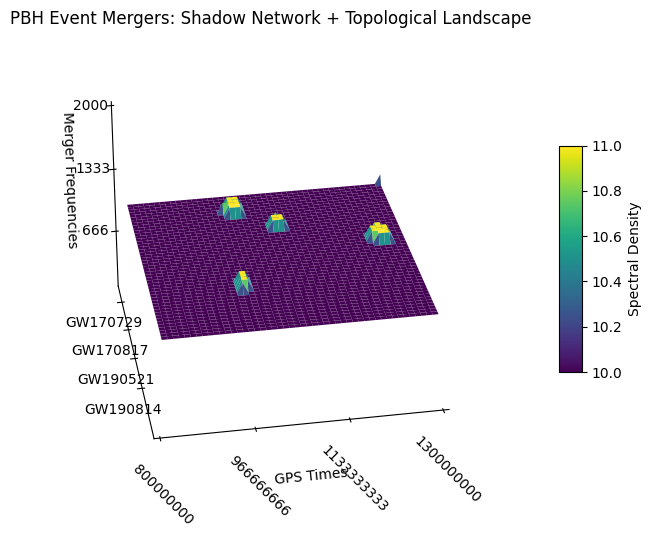

In [22]:

fig = plt.figure(figsize=(16,6), dpi=100)
ax = fig.add_subplot(111, projection='3d')

cmap='viridis'
#surf = ax.plot_surface(X, Y, H, rstride=20, cstride=20, alpha=0.8, cmap=cmap)
#surf = ax.plot_surface(X, Y, H, rstride=20, cstride=20, alpha=0.8, cmap=cmap)
H3=H2
#H2 = maximum_filter(H, size=4)
H2[H2>=5]=1

#H2 = gaussian_gradient_magnitude(H2, sigma=4)

surf = ax.plot_surface(X, Y, H3+10, cmap='viridis')
#cset = ax.contourf(X, Y, H2, zdir='z', offset=np.min(H3)-2, cmap=cmap)
#cset = ax.contourf(X, Y, H, zdir='x', offset=5, cmap=cmap)
#cset = ax.contourf(X, Y, H, zdir='y', offset=5, cmap=cmap)

bar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
bar.set_label("Spectral Density")
ax.set_xlabel('GPS Times')
ax.set_xlim(0,100)
ax.set_ylim(0, 100)
ax.set_zlabel('Merger Frequencies')
ax.set_zlim(np.min(H3)-100, np.max(H3))
ax.set_title('PBH Event Mergers: Shadow Network + Topological Landscape')
#ax.axis('off')
plt.grid(b=None)

ax.set_yticks([10,30,50,70])
ax.set_yticklabels(['GW170729','GW170817','GW190521','GW190814'])

ax.set_zticks(np.linspace(0,20,4))
ax.set_zticklabels(np.linspace(0,2000,4).astype(int))

ax.set_xticks(np.linspace(0,100,4))
ax.set_xticklabels(np.linspace(1300000000,800000000,4).astype(int))
# make the panes transparent
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

ax.set_zlim(1,20)
plt.xticks(rotation=-45)
ax.view_init(30, 80)
plt.tight_layout()
plt.show()


In [23]:
import networkx as nx
import random
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

Number of nodes 200


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

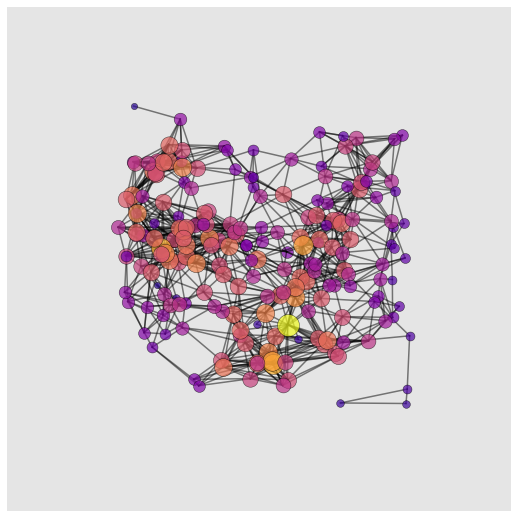

In [24]:
def generate_random_3Dgraph(n_nodes, radius, seed=None):
    if seed is not None:
        random.seed(seed)
    
    # Generate a dict of positions
    pos = {i: (random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1)) for i in range(n_nodes)}
    
    # Create random 3D network
    
    G = nx.random_geometric_graph(n_nodes, radius, pos=pos)
    return G

def network_plot_3D(G, angle, save=False):
    # Get node positions
    pos = nx.get_node_attributes(G, 'pos')
    
    # Get number of nodes
    n = G.number_of_nodes()
    print("Number of nodes", n)
    # Get the maximum number of edges adjacent to a single node
    edge_max = max([G.degree(i) for i in range(n)])
    # Define color range proportional to number of edges adjacent to a single node
    colors = [plt.cm.plasma(G.degree(i)/edge_max) for i in range(n)] 
    # 3D network plot
    with plt.style.context(('ggplot')):
        
        fig = plt.figure(figsize=(10,7))
        ax = Axes3D(fig)
        
        # Loop on the pos dictionary to extract the x,y,z coordinates of each node
        for key, value in pos.items():
            xi = value[0]
            yi = value[1]
            zi = value[2]
            
            # Scatter plot
            ax.scatter(xi, yi, zi, c=colors[key], s=20+20*G.degree(key), edgecolors='k', alpha=0.7)
        
        # Loop on the list of edges to get the x,y,z, coordinates of the connected nodes
        # Those two points are the extrema of the line to be plotted
        for i,j in enumerate(G.edges()):
            x = np.array((pos[j[0]][0], pos[j[1]][0]))
            y = np.array((pos[j[0]][1], pos[j[1]][1]))
            z = np.array((pos[j[0]][2], pos[j[1]][2]))
        
        # Plot the connecting lines
            ax.plot(x, y, z, c='black', alpha=0.5)
    
    # Set the initial view
    ax.view_init(30, angle)
    # Hide the axes
    ax.set_axis_off()
    if save is not False:
        plt.close('all')
    else:
        plt.show()
    
    return

n=200
G = generate_random_3Dgraph(n_nodes=n, radius=0.25, seed=1)
network_plot_3D(G,180, save=False)

In [25]:
graph = {
    "nodes": {
         "n1": {
             "label": "node1",
             "size": 1,
             "pos": [1,1,1]},
         "n2": {
            "label": "node2",
             "size": 2,
             "pos": [1,1,2]},
         "n3": {
            "label": "node3",
            "size": 4,
            "pos": [1,1,3]
         },
         "n4": {"label": "node4",
                "size": 1,
                "pos": [1,1,4]
               }
    },
       "edges" : [("n1", "n2" ,{ "label": "edge1", "type": "undirected", "weight": 2.0}),
                  ("n2", "n3" ,{ "label": "edge1", "type": "undirected", "weight": 2.0})
    ]
    
}

In [26]:
df = pd.read_csv("ligo_classifications.csv")

In [27]:
df['Event name '].unique()

array(['GW170817', 'GW170729', 'GW190814', 'GW190521'], dtype=object)

In [31]:
colors = {
    'Mass Cluster ': "red",
    'Spin Cluster ': "blue",
    'Luminosity Distance Cluster ': "green",
    'Redshift Cluster': "orange"
}

In [32]:
G2 = {
    "nodes":[],
    "edges":[] 
}

pos = []

cluster_centers = {}
for i, dd in df.groupby(['Event name ', 'Name of Cluster']):
    # make nodes
    locations = {}
    if dd['Event name '].iloc[0] not in cluster_centers:
        cluster_centers[dd['Event name '].iloc[0]] =  np.random.rand(1,3) * 4
    center = cluster_centers[dd['Event name '].iloc[0]] +  (np.random.rand()*4)
    gnodes = []
    for j, d in dd.iterrows():
        #print(d['Value of Each Node'], d['Event name '], d['Nodes in Cluster'])
        
        loc = center + np.random.rand(1,3)
        name = d['Nodes in Cluster'] + "_" + d['Event name ']
        G2['nodes'].append(
            (name , {
                'value': d['Value of Each Node'],
                'event': d['Event name '],
                'name_of_cluster': d['Name of Cluster'],
                'color': colors[d['Name of Cluster']],
                'pos': loc
            })
        )
        locations[name]  = loc
        gnodes.append(name)
        pos.append(loc)
    # make edges
    
    closest_nodes = {}

    for j, d in dd.iterrows():
        for k, l in dd.iterrows():
            dval = d['Value of Each Node']
            lval = l['Value of Each Node']
            
            fr = l['Nodes in Cluster'] + "_" + d['Event name ']
            to = d['Nodes in Cluster'] + "_" + d['Event name ']
            
            if dval < lval:
                fr = l['Nodes in Cluster'] + "_" + d['Event name ']
                to = d['Nodes in Cluster'] + "_" + d['Event name ']
                
            if fr != to:
                G2['edges'].append((fr, to))
                
                
    # add central node
    G2['nodes'].append(('Central Node' + d['Event name '] ,  {
        'value': 50, 
        'event': 'Central Node',
        'name_of_cluster': 'Central',
        'color': 'black',
        'pos': center
    }))
    
     
    for key in gnodes:
        pp = locations[key][0]
        cluster = key
        dist = np.linalg.norm(np.array(center)-np.array(pp))
        if cluster not in closest_nodes:
            closest_nodes[cluster] = (key, dist)
        elif dist < closest_nodes[cluster][1]:
            closest_nodes[cluster] = (key, dist)
    for k, edge in closest_nodes.items():
        G2['edges'].append((edge[0],'Central Node' + d['Event name ']))
    

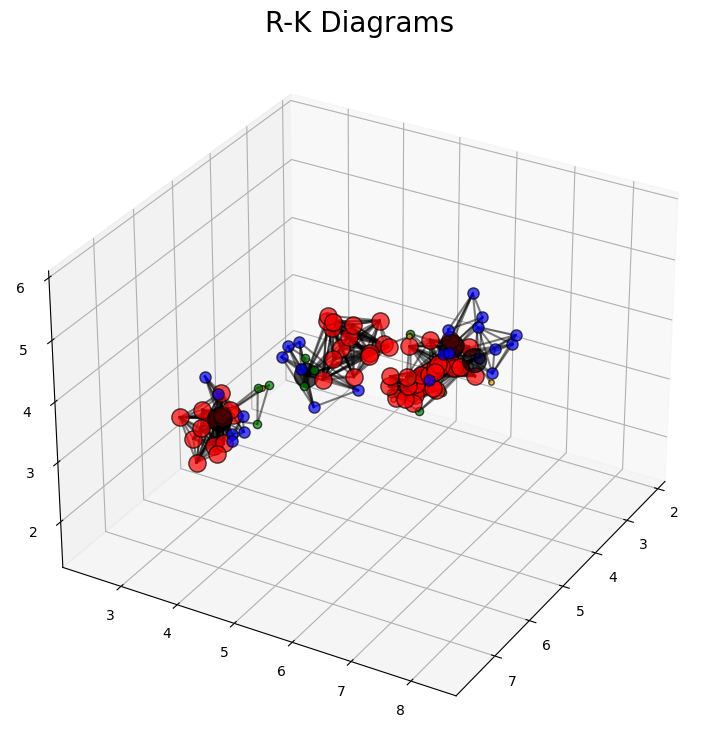

In [36]:
G = nx.Graph()
G2.items
G.add_nodes_from(G2['nodes'], pos=pos)
G.add_edges_from(G2['edges'])

def plot_network(G, angle, save):
    
    pos = nx.get_node_attributes(G, 'pos')  # Get number of nodes
    
#     for k,p in pos.items():
#         p[0][1] = 0
#     p[0][1] = 0

        
    n = G.number_of_nodes()
    #print("Number of nodes", n) # Get the maximum number of edges adjacent to a single node
    with plt.style.context(('default')):
        
        fig = plt.figure(figsize=(10,7))
        ax = Axes3D(fig)
        
        # Loop on the pos dictionary to extract the x,y,z coordinates of each node
        for key, value in pos.items():
            value = value[0]
            xi = value[0]
            yi = value[1]
            zi = value[2]

           # 5+10*G.degree(key)
            s = 5+10*G.degree(key)
            if 'Central Node' in key:
                s = 300
                #ax.scatter(xi, yi, zi, s=s, edgecolors='k', c=G.nodes()[key]['color'], alpha=0.7)

            ax.scatter(xi, yi, zi, s=s, edgecolors='k', c=G.nodes()[key]['color'], alpha=0.7)
      
        for i,j in enumerate(G.edges()):
            fr = j[0]
            to = j[1]            
            x = np.array((pos[fr][0][0], pos[to][0][0]))
            y = np.array((pos[fr][0][1], pos[to][0][1]))
            z = np.array((pos[fr][0][2], pos[to][0][2]))
            ax.plot(x, y, z, c='black', alpha=0.5)
    
    # Set the initial view
    ax.view_init(30, angle)

#     ax.set_xlabel('GPS Times')
#     ax.set_zlabel('SNR Values')
#     ax.set_ylabel('Peak Frequencies')

    ax.yaxis.grid(True, which='major')
    ax.xaxis.grid(True, which='major')
    ax.set_facecolor('white')
    ax.grid()
    ax.set_title("R-K Diagrams", size=20)
    

def add_central_node(G):
    pos = nx.get_node_attributes(G, 'pos') 
    posit = [x[1][0] for x in pos.items()]
    central_node = [np.mean(posit, axis=0)]
    
    G.add_nodes_from([('Central Node', {
        'value': 10, 
        'event': 'Central Node',
        'name_of_cluster': 'Central',
        'color': 'black',
        'pos': central_node
    })])
    
    
    closest_nodes = {}
    for key in G.nodes():
        pp = G.nodes()[key]['pos']
        cluster = G.nodes()[key]['name_of_cluster']
        dist = np.linalg.norm(np.array(central_node)-np.array(pp))
        if cluster not in closest_nodes:
            closest_nodes[cluster] = (key, dist)
        elif dist < closest_nodes[cluster][1]:
            closest_nodes[cluster] = (key, dist)
    
    for k, edge in closest_nodes.items():
        G.add_edges_from([(edge[0], 'Central Node')])
    return G
#G = add_central_node(G)
plot_network(G, 30, False)
#G.add_edges_from(graph['edges'])

In [72]:
import uuid

class RKModel:
    
    def __init__(self, clusters=None):
        clusters = [] if clusters is None else clusters
        self.clusters = clusters
        self._id = uuid.uuid4()
    
    def add_cluster(self, cluster):
        pass
    
    def merge_clusters(self):
        pass
    
    def visualize(self, ax):
        pass
    
class Node:
    
    def __init__(self, label, id, value, attributes):
        self.label = label
        self._id = id
        self.value = value
        self.attributes = attributes
        
    def serialize(self):
        return json.dumps({
            'label': self.label,
            'id': self._id,
            'value': self.value,
            'attributes': self.attributes
        })
    
    def to_nx_node(self):
        att = self.attributes
        att['value'] = self.value
        return (self._id, att)
    
class Edge:
    
    def __init__(self, from_id, to_id, label, weight, type="directed"):
        self.from_id = from_id
        self.to_id = to_id
        self.weight = weight
        self.type = type
        self.label = label
        
    def serialize(self):
        return {
            'from': self.from_id,
            'to': self.to_id,
            'weight': self.weight, 
            'type': self.type,
            'label': self.label
        }
    
    
    def to_nx_edge(self):
        return (self.from_id, self.to_id, {'weight': self.weigth, 'type': self.type, 'label': self.label})
    
class RKCluster:
    
    def __init__(self, name="", nodes=[], edges=[]):
        self.nodes = nodes
        self.edges = edges
        self._g = nx.Graph()
        self.name = name
        self._id = uuid.uuid4()
        
    def compute_centroid(self):
        pass
    
    def add_graph(self, graph):
        self._g = graph
        
    def add_node(self, node=None):
        self.nodes.append(node)
    
    def add_edge(self, edge):
        self.edges.append(edge)
        
    def visualize(self, ax):
        return ax